## 서울 예측 모델(SimpleRNN)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

In [2]:
file_path = "./dataset/seoul_pm10.csv"
data = pd.read_csv(file_path, encoding='cp949')
data.head()

,date,area,pm10,pm2.5
0,2022-12-31 23:00,강남구,57.0,44.0
1,2022-12-31 23:00,강동구,68.0,55.0
2,2022-12-31 23:00,강북구,59.0,42.0
3,2022-12-31 23:00,강서구,62.0,40.0
4,2022-12-31 23:00,관악구,57.0,38.0


In [3]:
# 결측치 확인
print(data.isnull().sum())

date        0
area        0
pm10     4916
pm2.5    4247
dtype: int64


In [4]:
# 날짜 형식으로 변환
data['date'] = pd.to_datetime(data['date'])
# 날짜순으로 정렬
data = data.sort_values('date')

In [5]:
# 결측치를 평균값으로 대체
mean_value10 = data['pm10'].mean()
data['pm10'] = data['pm10'].fillna(mean_value10)
mean_value25 = data['pm2.5'].mean()
data['pm2.5'] = data['pm2.5'].fillna(mean_value25)

In [6]:
# target 추출
pm10_data = data['pm10'].values
pm25_data = data['pm2.5'].values

In [7]:
scaler_pm10 = MinMaxScaler(feature_range=(0, 1))
scaler_pm25 = MinMaxScaler(feature_range=(0, 1))

scaled_pm10 = scaler_pm10.fit_transform(pm10_data.reshape(-1, 1))
scaled_pm25 = scaler_pm25.fit_transform(pm25_data.reshape(-1, 1))

In [8]:
# 데이터셋 생성 함수
def create_dataset(dataset, look_back=24):
    X, y = [] , []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i+look_back, 0])
        y.append(dataset[i+look_back,0])
    return np.array(X), np.array(y)

In [9]:
look_back = 24 
X_pm10, y_pm10 = create_dataset(scaled_pm10, look_back)
X_pm25, y_pm25 = create_dataset(scaled_pm25, look_back)

In [10]:
if len(pm10_data.shape) == 1:
    pm10_data = pm10_data.reshape(-1, 1)

if len(pm25_data.shape) == 1:
    pm25_data = pm25_data.reshape(-1, 1)

In [11]:
train_size10 = int(len(X_pm10) * 0.8)

X_pm10_train, X_pm10_test = X_pm10[:train_size10], X_pm10[train_size10:]
y_pm10_train, y_pm10_test = y_pm10[:train_size10], y_pm10[train_size10:]

train_size25 = int(len(X_pm25) * 0.8)
X_pm25_train, X_pm25_test = X_pm25[:train_size25], X_pm25[train_size25:]
y_pm25_train, y_pm25_test = y_pm25[:train_size25], y_pm25[train_size25:]

In [12]:
model_pm10 = Sequential([
    SimpleRNN(50, return_sequences=False, input_shape=(look_back, pm10_data.shape[1])),
    Dense(pm10_data.shape[1])
])

model_pm25 = Sequential([
    SimpleRNN(50, return_sequences=False, input_shape=(look_back, pm25_data.shape[1])),
    Dense(pm25_data.shape[1])
])

In [13]:
model_pm10.compile(optimizer='adam', loss='mean_squared_error')

model_pm25.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
# from keras.callbacks import EarlyStopping

# # early stopping 추가
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True
# )

# 모델 훈련
# history = model.fit(
#     X_train, 
#     y_train,
#     epochs=5,
#     batch_size=128,
#     validation_data=(X_test, y_test)
    # ,
    # callbacks=[early_stopping]
# )

In [15]:
history_pm10 = model_pm10.fit(X_pm10_train, y_pm10_train, epochs=50, batch_size=32, validation_data=(X_pm10_test, y_pm10_test))

history_pm25 = model_pm25.fit(X_pm25_train, y_pm25_train, epochs=50, batch_size=32, validation_data=(X_pm25_test, y_pm25_test))


Epoch 1/50
5694/5694 [==============================] - 20s 3ms/step - loss: 2.2751e-04 - val_loss: 4.2143e-04
Epoch 2/50
5694/5694 [==============================] - 19s 3ms/step - loss: 2.2006e-04 - val_loss: 3.5442e-04
Epoch 3/50
5694/5694 [==============================] - 20s 4ms/step - loss: 2.1683e-04 - val_loss: 3.1610e-04
Epoch 4/50
5694/5694 [==============================] - 21s 4ms/step - loss: 2.1408e-04 - val_loss: 4.3597e-04
Epoch 5/50
5694/5694 [==============================] - 20s 4ms/step - loss: 2.1376e-04 - val_loss: 3.5522e-04
Epoch 6/50
5694/5694 [==============================] - 20s 4ms/step - loss: 2.1329e-04 - val_loss: 4.1800e-04
Epoch 7/50
5694/5694 [==============================] - 21s 4ms/step - loss: 2.1314e-04 - val_loss: 3.7297e-04
Epoch 8/50
5694/5694 [==============================] - 21s 4ms/step - loss: 2.1222e-04 - val_loss: 3.9330e-04
Epoch 9/50
5694/5694 [==============================] - 21s 4ms/step - loss: 2.1171e-04 - val_loss: 3.7562e-04
E

In [25]:
# 5. 예측
predictions_pm10 = model_pm10.predict(X_pm10_test)
predictions_pm10 = scaler_pm10.inverse_transform(predictions_pm10)

predictions_pm25 = model_pm25.predict(X_pm25_test)
predictions_pm25 = scaler_pm25.inverse_transform(predictions_pm25)

In [26]:
# 실제 값 복원
actual_pm10 = scaler_pm10.inverse_transform(y_pm10_test.reshape(-1,1))
actual_pm25 = scaler_pm25.inverse_transform(y_pm25_test.reshape(-1,1))

In [27]:
# 시각화를 위한 날짜 인덱스 만들기
test_dates = data['date'].values[-(len(predictions_pm10)):] 
test_dates = data['date'].values[-(len(predictions_pm25)):] 

C:\Users\human-14\AppData\Local\Temp\ipykernel_5468\2247282772.py:13: UserWarning: Glyph 13197 (\N{SQUARE MU G}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\human-14\AppData\Local\Temp\ipykernel_5468\2247282772.py:13: UserWarning: Glyph 13221 (\N{SQUARE M CUBED}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Ai_Project\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13197 (\N{SQUARE MU G}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Ai_Project\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13221 (\N{SQUARE M CUBED}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


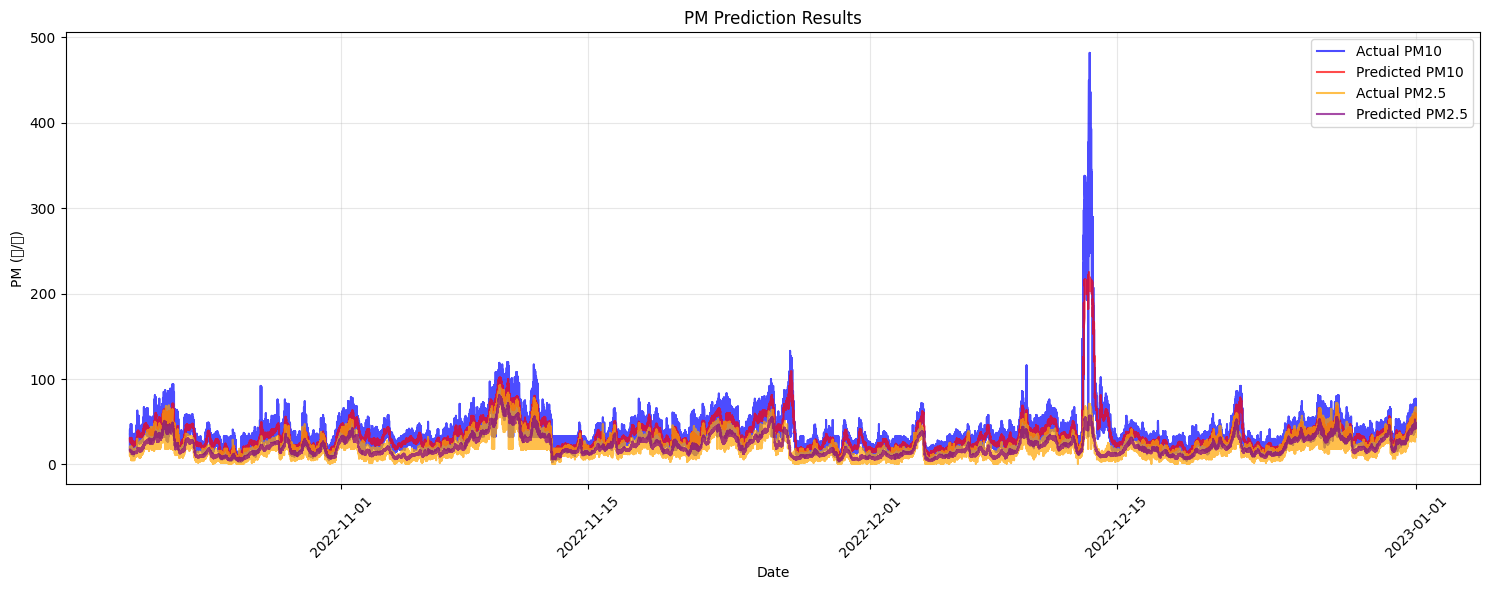

In [28]:
# 시각화
plt.figure(figsize=(15, 6))
plt.plot(test_dates, actual_pm10, label='Actual PM10', color='blue', alpha=0.7)
plt.plot(test_dates, predictions_pm10, label='Predicted PM10', color='red', alpha=0.7)
plt.plot(test_dates, actual_pm25, label='Actual PM2.5', color='orange', alpha=0.7)
plt.plot(test_dates, predictions_pm25, label='Predicted PM2.5', color='purple', alpha=0.7)
plt.title('PM Prediction Results')
plt.xlabel('Date')
plt.ylabel('PM (㎍/㎥)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# MAE, RMSE 같은 평가 지표도 출력
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae10 = mean_absolute_error(actual_pm10, predictions_pm10)
rmse10 = np.sqrt(mean_squared_error(actual_pm10, predictions_pm10))
print(f'MAE for pm10: {mae10:.2f}')
print(f'RMSE for pm10: {rmse10:.2f}')


mae25 = mean_absolute_error(actual_pm25, predictions_pm25)
rmse25 = np.sqrt(mean_squared_error(actual_pm25, predictions_pm25))
print(f'MAE for pm2.5: {mae25:.2f}')
print(f'RMSE for pm2.5: {rmse25:.2f}')

MAE for pm10: 5.39
RMSE for pm10: 10.71
MAE for pm2.5: 3.49
RMSE for pm2.5: 4.84


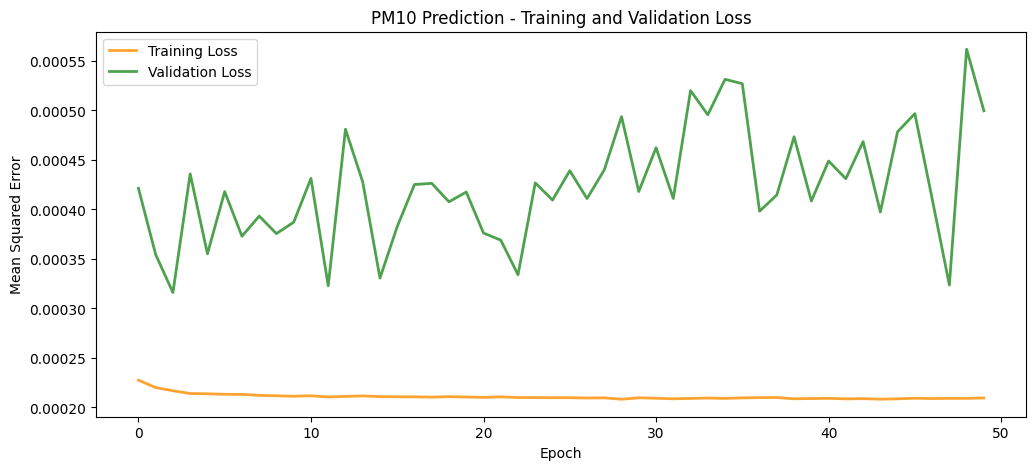

In [30]:
plt.figure(figsize=(12, 5))
plt.plot(history_pm10.history['loss'], label='Training Loss', color='#FF8C00', linewidth=2, alpha=0.8)
plt.plot(history_pm10.history['val_loss'], label='Validation Loss', color='#228B22', linewidth=2, alpha=0.8)
plt.title('PM10 Prediction - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

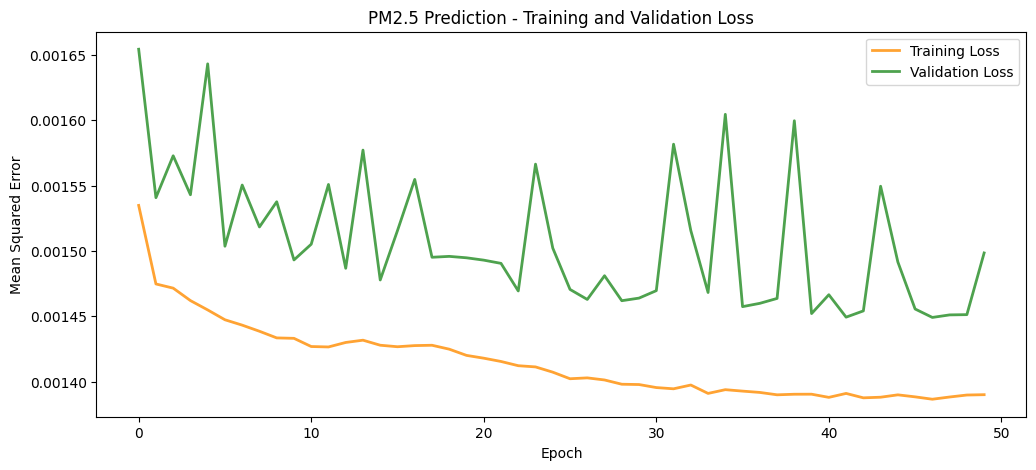

In [31]:
plt.figure(figsize=(12, 5))
plt.plot(history_pm25.history['loss'], label='Training Loss', color='#FF8C00', linewidth=2, alpha=0.8)
plt.plot(history_pm25.history['val_loss'], label='Validation Loss', color='#228B22', linewidth=2, alpha=0.8)
plt.title('PM2.5 Prediction - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [32]:
# 최종 pm10 loss 값들 출력
final_train_loss = history_pm10.history['loss'][-1]
final_val_loss = history_pm10.history['val_loss'][-1]
print(f'Final Training Loss for pm10: {final_train_loss:.4f}')
print(f'Final Validation Loss for pm10: {final_val_loss:.4f}')

Final Training Loss for pm10: 0.0002
Final Validation Loss for pm10: 0.0005


In [33]:
# 최종 pm2.5 loss 값들 출력
final_train_loss = history_pm25.history['loss'][-1]
final_val_loss = history_pm25.history['val_loss'][-1]
print(f'Final Training Loss for pm2.5: {final_train_loss:.4f}')
print(f'Final Validation Loss for pm2.5: {final_val_loss:.4f}')

Final Training Loss for pm2.5: 0.0014
Final Validation Loss for pm2.5: 0.0015
